In [1]:
import os
import numpy as np
import random

import torch
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms

from CapsuleNet import CapsuleNetwork, CapsuleLoss, display_images
from utils import DICOMCoarseDataset, display_data_loader_batch, TransformDataset, TensorFolderDataset

In [2]:
scenario = 3
data_augmentation = True
save_folder_base = f"./data/scenario{scenario}/"
comparison_base = f"./data/scenario1/test"

In [3]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
classes = ["nodule", "non-nodule"]
train_ratio = 0.8
image_size = 80

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

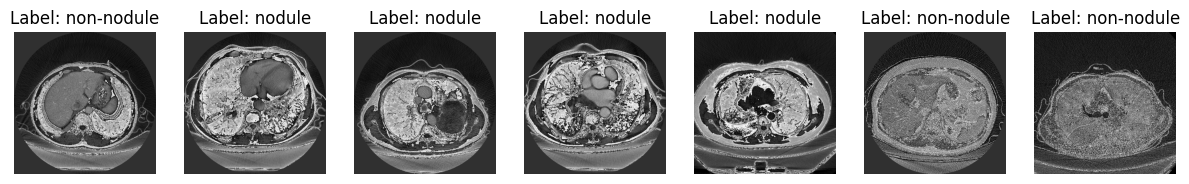

In [4]:
train_transforms = None

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

if data_augmentation:
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
        transforms.RandomResizedCrop((224, 224),      # Random crop and resize to simulate zooming
                        scale=(0.8, 1.2),  # Scale for zoom in/out
                        ratio=(0.9, 1.1)),
        transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
        transform
    ])
else: 
    train_transforms = transform

dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=["nodule", "non-nodule"], scenario=scenario)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=["nodule", "non-nodule"], transform=transform, scenario=1)
dataset.visualize_images(num_images=7)

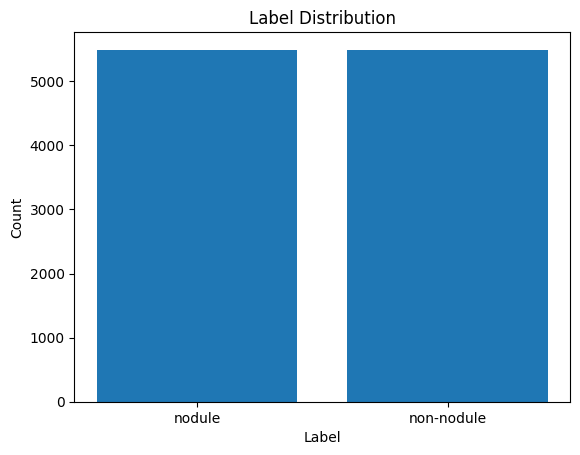

In [5]:
dataset.display_label_distribution()

Train size: 6031 --- Test size: 2198


c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


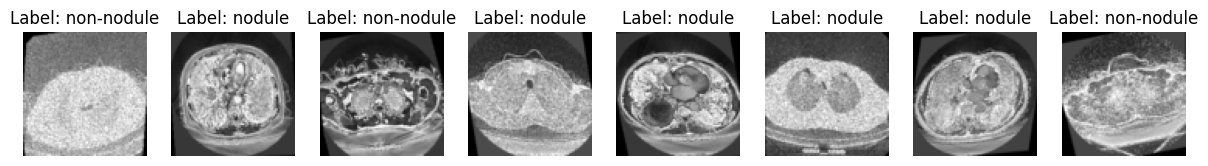

In [6]:
train_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "train_filtered"))
test_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "test"))
train_dataset = TransformDataset(train_dataset_base, transform=train_transforms)
test_dataset = TransformDataset(test_dataset_base, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print(f"Train size: {len(train_dataset_base)} --- Test size: {len(test_dataset_base)}")
display_data_loader_batch(train_loader, classes)

In [7]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=6400, bias=True)
      (5): Sigmoid()
    )
  )
)


In [8]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [9]:
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)

Epoch: 1 	Training Loss: 7.19437718
Epoch: 1 	Training Loss: 3.37735391
Epoch: 1 	Training Loss: 3.30255747
Epoch: 1 	Training Loss: 3.14287472
Epoch: 1 	Training Loss: 3.13475084
Epoch: 1 	Training Loss: 3.12169385
Epoch: 1 	Training Loss: 2.86355352
Epoch: 1 	Training Loss: 2.75765872
Epoch: 1 	Training Loss: 2.48704529
Epoch: 1 	Training Loss: 2.43130994
Epoch: 1 	Training Loss: 2.22089672
Epoch: 1 	Training Loss: 2.09829903
Epoch: 1 	Training Loss: 1.87218845
Epoch: 1 	Training Loss: 1.85079694
Epoch: 1 	Training Loss: 1.85929012
Epoch: 1 	Training Loss: 1.69001222
Epoch: 1 	Training Loss: 1.67330611
Epoch: 1 	Training Loss: 1.62429667
Epoch: 1 	Training Loss: 1.70143914
Epoch: 1 	Training Loss: 1.55627298
Epoch: 1 	Training Loss: 1.63109016
Epoch: 1 	Training Loss: 1.59182167
Epoch: 1 	Training Loss: 1.54951596
Epoch: 1 	Training Loss: 1.56103086
Epoch: 1 	Training Loss: 1.59434891
Epoch: 1 	Training Loss: 1.53787529
Epoch: 1 	Training Loss: 1.60342848
Epoch: 1 	Training Loss: 1.4

Test Loss: 1.20920457

Test Accuracy of     0: 77.83% (867/1114)
Test Accuracy of     1: 60.26% (640/1062)

Test Accuracy (Overall): 69.26% (1507/2176)


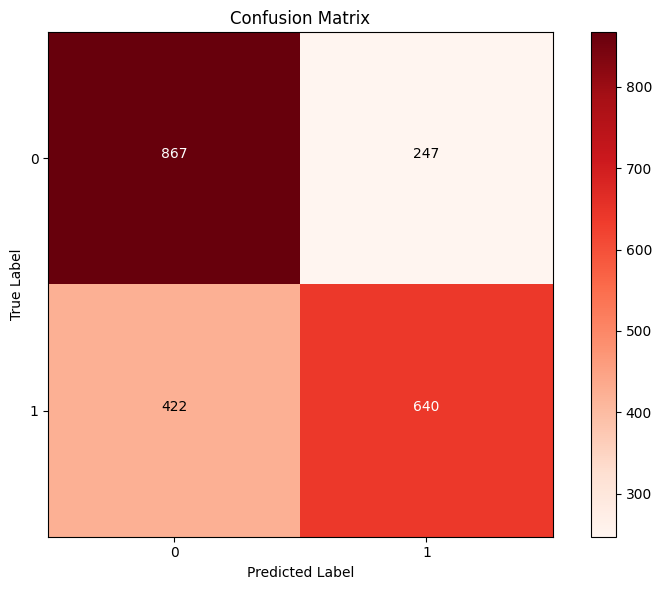

In [10]:
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Test Loss: 1.18252707

Test Accuracy of     0: 77.85% (875/1124)
Test Accuracy of     1: 59.09% (634/1073)

Test Accuracy (Overall): 68.68% (1509/2197)


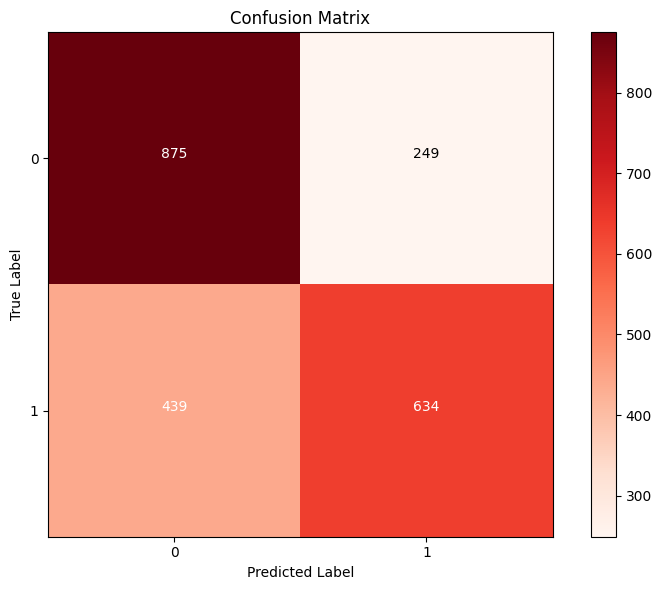

In [11]:
comparison_dataset_base = TensorFolderDataset(comparison_base)
comparison_dataset = TransformDataset(comparison_dataset_base, transform=transform)
comparison_loader = DataLoader(comparison_dataset, batch_size=batch_size, shuffle=False)

caps_outputs, images, reconstructions = capsule_net.test_model(criterion, comparison_loader)

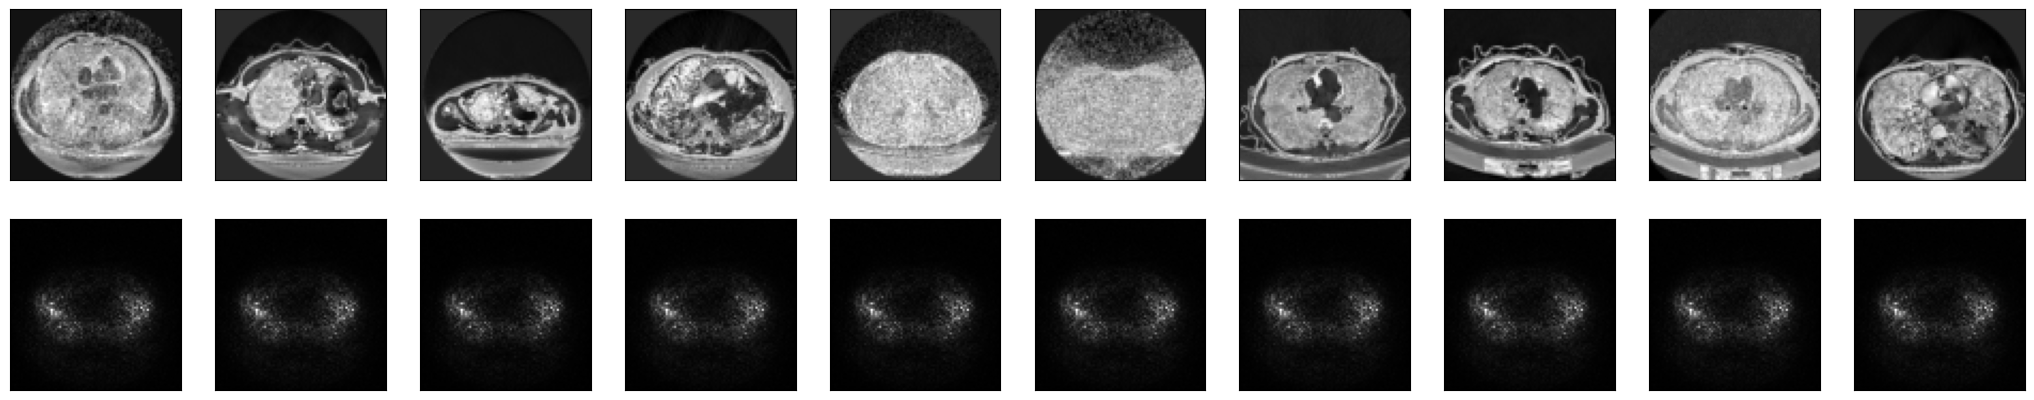

In [12]:
display_images(images, reconstructions)